<a href="https://colab.research.google.com/github/jhmuller/XCS224/blob/main/XCS224W_Colab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Colab 3**

In Colab 2 you constructed GNN models by using PyTorch Geometric's built in GCN layer, `GCNConv`. In this Colab you will go a step deeper and implement your GNN layers directly: **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) and **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)). Using these GNN layers you will run and test your models on the CORA dataset, a standard citation network benchmark dataset.

Next, you will learn how to use [DeepSNAP](https://snap.stanford.edu/deepsnap/), a Python library enabling efficient deep learning on graphs. With DeepSNAP you will learn how to easily split graphs in different ways and apply graph dataset transformations.

Lastly, using DeepSNAP's transductive link prediction dataset spliting functionality, you will construct a simple GNN model for the task of edge property prediction (link prediction).

**Note**: Make sure to **sequentially run all the cells in each section** so that the intermediate variables / packages will carry over to the next cell

Have fun and good luck on Colab 3 :)

## Building + Debugging Notes
While working through this Colab and future Colabs, we strongly encourage you to follow a couple of building / debugging strategies:
- During debugging make sure to run your notebook using the CPU runtime. You can change the notebook runtime by selecting `Runtime` and then `Change runtime type`. From the dropdown, select `None` as the `hardware accelerator`.
- When working with PyTorch and Neural Network models, understanding the shapes of different tensors, especially the input and output tensors is incredibly helpful.
- When training models, it is helpful to start by only running 1 epoch or even just a couple of batch iterations. This way you can check that all your tensor shapes and logic match up, while also tracking expected behavior, such as a decreasing training loss. Remember to comment out / save the default number of epochs that we provide you.


# Device
We recommend using a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [1]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  if os.environ["USER"] and os.environ["USER"].lower() != 'john':
      !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
      !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
      !pip install torch-geometric
      !pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [2]:
import torch_geometric
torch_geometric.__version__

'2.0.3'

# 1) GNN Layers

## Implementing Layer Modules

In Colab 2, you implemented a GCN model for node and graph classification tasks. However, for that notebook you took advantage of PyG's built in GCN module, similar to the way you might use PyTorch's built in CNN layer. For Colab 3, we provide a general Graph Neural Network Stack (i.e. the logic for applying multiple GNN layers with a post-message passing classification head). Using this flexible class definition, you will plugin and compare the performance of your own message passing layer implementations: GraphSAGE and GAT.

You will use your layer implemenations for node classification on the CORA dataset, a standard citation network benchmark. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node or document in the graph is assigned a class label and features based on the documents binarized bag-of-words representation. Specifically, the Cora graph has 2708 nodes, 5429 edges, 7 prediction classes, and 1433 features per node. 

## GNN Stack Module

Below is our provided implementation of a general GNN stack, where you can plugin any GNN layer, such as **GraphSage**, **GAT**, etc. This module is provided for you. Your implementations of the **GraphSage** and **GAT** layers will function as components in the GNNStack Module.

In [3]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, you need to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, 
            #    you need to change the for-loop that builds up self.convs to be
            #      self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            #          and also the firstl
            #      Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Creating Your Own Message Passing Layer

Now it is time to implement your own message passing layers! Working through this part will help you become acutely familiar with the behind the scenes work of implementing Pytorch Message Passing Layers, allowing you to build you own custom GNN models. In doing so, you will work with and implement <br><b>3 critcal functions</b> needed to define a PyG Message Passing Layer:
<ol><li>`forward`, <li> `message`, and <li>`aggregate`.</ol>

Before diving head first into the coding details, let us quickly review the key components of the message passing process.   

### Central node message Passing
First, we focus on a single round of messsage passing with respect to a single node $x$, which we refer to as the central node. The goal of the $lth$ layer of message passing is to update $x$'s feature vector from $x^{l-1}$ to $x^l$. To do so, we implement the following steps:  
<ol>
    <li>each neighboring node $v$ passes its current message $v^{l-1}$ across the edge $(v, x)$, 
    <li> for the node $x$, we aggregate all the messages of neighboring nodes (for example through a sum or mean),
     <li> we transform the aggregated information by e.g. applying linear and non-linear transformations. 
 </ol>  
 Altogether, the message passing process is applied such that every node $u$ in our graph updates its embedding through acting as the central node $x$ in step 1-3 described above. 

### Propagating and Transforming
Second, let's apply this process of propagating and transforming information within the graph to that of coding a single message passing layer. Overall, the general paradigm of message passing layers is:  
<ol> 
    <li> pre-processing
    <li> **message passing** / propagation 
    <li>post-processing. 
</ol>
The `forward` function that you will implement captures this execution logic. Namely, the `forward` function handles the pre and post-processing of node features / embeddings, as well as initiates message passing by calling the `propagate` function. 


The `propagate` function encapsulates the actual message passing process within the graph! It does so by calling three important functions: 
<ol> 
    <li>`message`
    <li>`aggregate`, and
    <li>`update`. 
 </ol>
 Your implementation will vary slightly from this, as you will not explicitly implement `update`, but instead place the logic for updating node embeddings after message passing and within the `forward` function. To be more specific, after information is propagated (message passing + aggregation), we can further transform the node embeddings outputed by `propagate`. Overall, the output of `forward` is exactly the node embeddings after one GNN layer.
 
### side bar
forward = pre-process + propogate + post-process<br>
propogate = message + aggregate<br>
post-process examples include transformations<br>

### Putting it all together
Lastly, before starting to implement our own layer, let us dig a bit deeper into each of the functions described above:

1. 

```
def propagate(edge_index, x=(x_src, x_dst), extra=(extra_src, extra_dst), size=size):
```
Calling `propagate` initiates the message passing process. Looking at the function parameters, we highlight a couple of key parameters. 

  - `edge_index` is passed to the forward function and captures the edge structure of the graph. `edge_index` is of shape - `[2, E]`, where `edge_index[:, e]` represents a single edge $e$ in the graph.
  - `x=(x_src, x_dst)` represents the node features that will be used in message passing, where we have the flexibility to distinguish the features of source (<b>x_src</b>) vs. destination (<b>x_dst</b>) nodes (e.g. with different transformations). Common notation is to think of the src node features as the node features used for sending messages and dst node features as the central node features that will be receiving these messages. Note, while in this notebook the src and dst matrices will be the same shape - $[N, d]$ (i.e. coming from the same set of nodes), we will see later in the course cases where these nodes can differ.

  - `extra=(extra_src, extra_dst)` represents additional information that we can associate with each node beyond its current feature embedding. In fact, we can include as many additional parameters of the form `param=(param_src, param_dst)` as we would like. We highlight that differentiating betwee `_src` and `_dst` allows us to differentiate the features used for central and neighboring node features later in the message passing process. 

  The output of the `propagate` function is a matrix of node embeddings after the message passing process and has shape $[N, d]$.

2. 
```
def message(x_j, ...):
```
The `message` function is called by `propagate` and constructs the messages from neighboring nodes (src nodes) to central nodes (dst nodes). Following PyG convention, we subscript variables dealing with src nodes with `_j` and dst nodes  with `_i`. 

  - `x_j` represents the matrix of node features for *each src node of each edge* in the graph. Specifically, messages are constructed along each edge $(j, i) \in \mathcal{E}$, where edge_index is used extract node feature information to construct `x_j` as `x_j = x_src[edge_index[0, :], :]`. Thus, `x_j` has shape $[|\mathcal{E}|, d]$!

  - `...` represent any additional arguments passed to `propagate`, from which we can differentiate between src and dst node types by appending `_i` or `_j` to the variable name. In implementing GAT you will see how you can leverage accessing additional variables passed to propagate.

  Critically, we emphasize that the output of the `message` function is a matrix of messages ready to be aggregated, having shape $[|\mathcal{E}|, d]$, where these messages are constructed by applying different potential transformations to the initial src node embedding messages.

  **Note** Understanding the message passing process is definitely a confusing concept; however, it is very helpful to think of the `message` function acting on each individual edges in the graph (i.e. producing a message for each directed edge $(j, i)$). Moreover, for undirected graphs since we store both directions of each edge, each node $u$ acts both as a src and dst node, sending messages to its neighbors and then also aggregating messages from its same set of neighbors.


3. 
```
def aggregate(self, inputs, index, dim_size = None):
```
Lastly, the `aggregate` function is used to aggregate the messages from neighboring nodes. Looking at the parameters, we highlight:

  - `inputs` represents a matrix of the messages passed from neighboring nodes (i.e. the output of the `message` function).
  - `index` is an array with length equal to the number of rows of `inputs` and tells us the central node $i$ associated with each message (row) in the `inputs` matrix. Thus, `index` tells us which rows / messages to aggregate for each central node $i$ - i.e. all messages with associated edges $(*, i) \in \mathcal{E}$.

  The output of `aggregate` is of shape $[N, d]$.


For additional resources refer to the PyG documentation for implementing custom message passing layers:   <br>https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

## GraphSage Implementation

For our first GNN layer, you will implement the well known GraphSage ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer! 

For a given *central* node $v$ with current embedding $h_v^{l-1}$, the message passing update rule to tranform $h_v^{l-1} \rightarrow h_v^l$ is as follows: 

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $W_l$ and $W_r$ are learnable weight matrices and the nodes $u$ are *neighboring* nodes. Additionally, you will use mean aggregation:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

One thing to note is that we have added a **skip connection** to your GraphSage implementation through the term $W_l\cdot h_v^{(l-1)}$. 

Before implementing this update rule, we encourage you to think about how different parts of the GraphSage formulas correspond with the functions outlined earlier: 
<ol> <li> `forward`, <li> `message`, and <li> `aggregate`.</ol> 

As a hint, you are given what the aggregation function is (i.e. mean aggregation)! Now the question remains,
<ul><li>what are the messages passed by each neighbor nodes? and <li>when do we call the `propagate` function? </ul>

Note: in this case the message function or messages are actually quite simple. Additionally, remember that the `propagate` function encapsulates the operations of / the outputs of the combined `message` and `aggregate` functions.


Lastly, $\ell$-2 normalization of the node embeddings is applied after each iteration.


<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>

In [4]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############# Your code here #############
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.lin_l = torch.nn.Linear(in_channels, out_channels)
        self.lin_r = torch.nn.Linear(in_channels, out_channels)
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############# Your code here #############
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct message passing.
        #    1.1 See the description of propagate above or the following link for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 You will only use the representation for neighbor nodes (x_j) in message passing. 
        #        Thus, you can simply pass the same representation for src / dst as x=(x, x). 
        #        Although we give this to you, try thinking through what this means following
        #        the descriptions above.
        # 2. Update your node embeddings with a skip connection.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        #
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        
        # pre-process
        # message
        out = self.propagate(edge_index, x=x, size=size)
        out = self.lin_l(out)
        x_r = x[1]
        import pdb
        #pdb.set_trace()
        out += self.lin_r(x_r)           
        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)        
        
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############# Your code here #############
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on 
        # what message each individual neighboring node passes during aggregation.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        
        # x_j represents the matrix of node features for each src node of each edge in the graph. 
        # Specifically, messages are constructed along each edge (𝑗,𝑖)∈endge_index,
        # where edge_index is used extract node feature information to construct x_j 
        # as x_j = x_src[edge_index[0, :], :]. Thus, x_j has shape [||,𝑑]

        # represent any additional arguments passed to propagate, 
        # from which we can differentiate between src and dst node types by appending _i or _j to the variable name. 
        # In implementing GAT you will see how you can leverage accessing additional variables passed to propagate.

        # Critically, we emphasize that the output of the message function is a matrix of messages 
        # ready to be aggregated, having shape [||,𝑑]
        # , where these messages are constructed by applying different potential transformations 
        # to the initial src node embedding messages.
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############# Your code here #############
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        
        #inputs represents a matrix of the messages passed from neighboring nodes ( of the message function).
        # index is an array with length equal to the number of rows of inputs and tells us the central node 𝑖
        #  associated with each message (row) in the inputs matrix. 
        # Thus, index tells us which rows / messages to aggregate for each central node 𝑖 - 
        #  i.e. all messages with associated edges (∗,𝑖)∈ edge_list

        
        # The output of aggregate is of shape [𝑁,𝑑]

        #out = super(GraphSage, self).aggregate(inputs, index, dim_size=node_dim)
        out = torch_scatter.scatter(inputs, index, node_dim)
        ############################################################################

        return out


In [5]:
#%pdb

## GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, you will learn how attention mechanisms can be used to perform node classification over graph-structured data through the usage of Graph Attention Networks (GATs) ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function. Like before, a graph attention layer $l$ transforms the set of node features $\mathbf{h^{l-1}} = \{h_1^{l-1}, h_2^{l-1}, \dots, h_N^{l-1}$\}, $h_i^{l-1} \in R^F$ $\rightarrow$ $\mathbf{h^{l}} = \{h_1^{l}, h_2^{l}, \dots, h_N^{l}$\}, $h_i^{l} \in R^{F'}$.

Now let's see how this transformation is performed for each graph attention layer. First, a shared linear transformation parameterized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. 

Next, we perform self-attention on the nodes using a shared attention function $a$:
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}
\end{equation}

that computes the attention coefficients, capturing the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}

The most general formulation of self-attention allows every node to attend to all other nodes, which drops all structural information. However, to utilize the graph structure in the attention mechanisms, we use **masked attention**. In masked attention, we only compute attention coefficients $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is the set of neighbors for node $i$ in the graph. Namely, we only compute attention along the edges of the graph. 

To easily compare coefficients across nodes, we normalize the coefficients across a node $i$'s neighbors $j$ using the softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by weight vectors $\overrightarrow{a_l} \in \mathbb{R}^{F'}$ and $\overrightarrow{a_r} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Letting $\cdot^T$ represent transposition, the coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote `alpha_l` = $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...] \in \mathcal{R}^n$ and `alpha_r` = $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...] \in \mathcal{R}^n$, where again $n$ is the number of nodes in the graph.


For every GAT layer, after the attention coefficients are computed, the aggregation function for a node $i$ is computed as a weighted sum over the messages from neighboring nodes $j$ **weighted by the attention weights** $\alpha_{ij}$. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

At this point, we have covered a lot of information! Before reading further about multi-head attention, we encourage you to go again through the exercise of thinking about what components of the attention mechanism correspond with the different functions: 1) `forward`, 2) `message`, and 3 `aggregate`. 

- Hint 1: Our aggregation is very similar to that of GraphSage except now we are using sum aggregation.
- Hint 2: The terms we aggregate over represent the individual message that each neighbor node j sends. Thus, we see that $\alpha_{ij}$ is actually part of the message each node sends and should be computed during the message step. This makes sense since each attention weight is associated with a single edge in the graph.
- Hint 3: Look at the terms in the definition of $\alpha_{ij}$. What values can you pre-process and pass as parameters to the `propagate` function (i.e. those computed only over the nodes *that do not* require edge information). The parameters of `message(..., x_j, alpha_j, alpha_i, ...)` should give a good hint.  
- Hint 4: Remember that parameters accessed in the `message` function are extracted from parameters passed to propagate using `edge_index`; thus, their first dimension has shape $|E|$.

### Multi-Head Attention
To stabilize the learning process of self-attention, you will use multi-head attention. To do this you use $K$ **independent** attention mechanisms, or ``heads'', to compute output features exactly as described in the above equations. Then, you simply concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concatenation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$. 

**Note:** We recommend first thinking through the implementation of single head attention. Switching to multi-head attention then requires thinking through adding an extra dimension $K$ to effectively compute $K$ separate single head attention outputs.

In [6]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############# Your code here #############
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # 
        # Pay attention to dimensions of the linear layers, especially when
        # implementing multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        self.lin_l = torch.nn.Linear(in_channels, self.heads*out_channels)
        ############################################################################

        self.lin_r = self.lin_l

        ############# Your code here #############
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # 1. Note that these are vectors not matrices!
        # 2. Be mindful of when you want to include multi-head attention.
        # 3. Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.att_l = Parameter(torch.Tensor(1, self.heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, self.heads, out_channels))
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############# Your code here #############
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See here for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        import pdb
        #pdb.set_trace()
        #x_l, x_r = x
        x_l = self.lin_l(x).view(-1, H, C)
        x_r = self.lin_r(x).view(-1, H, C)        
            
        alpha_l = (x_l * self.att_l).sum(dim=-1)
        alpha_r = None if x_r is None else (x_r * self.att_r).sum(-1)
        alpha = (alpha_l, alpha_r)
        out = self.propagate(edge_index, x=(x_l, x_r), size=size, alpha=alpha)
        import pdb
        #pdb.set_trace()
        out = out.view(-1, H*C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############# Your code here #############
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the attention weights using alpha_i and alpha_j,
        #    and apply leaky ReLU.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)

        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = x_j * alpha.unsqueeze(-1)
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############# Your code here #############
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        #   https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        import pdb
        #pdb.set_trace()
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='sum')
        ############################################################################
    
        return out

## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.

In [7]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [8]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Let's Start the Training!

You will be working on the CORA dataset on node-level classification.

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!

**Submit your best accuracy and loss on Gradescope.**

/home/john/anaconda3/envs/pgenv/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [01:26<00:00,  5.76Epochs/s]


Maximum test set accuracy: 0.774
Minimum loss: 0.09873542189598083
Saving Model Predictions for Model Type GraphSage

Node task. test set size: 1000



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.46Epochs/s]


Maximum test set accuracy: 0.787
Minimum loss: 0.021586384624242783
Saving Model Predictions for Model Type GAT



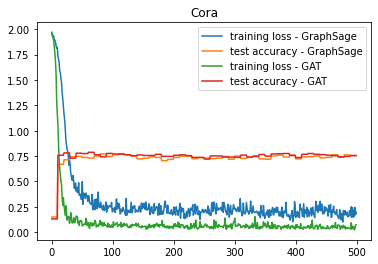

In [9]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in [ "GraphSage", 'GAT', ]: # 'GAT', 
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()


## Question 1.1: What is the maximum accuracy obtained on the test set for GraphSage? (20 points)

Running the cell above will show the results of your best model and save your best model's predictions to a file named *CORA-Node-GraphSage.csv*.  

As you have seen before you can view this file by clicking on the *Folder* icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.

## Question 1.2: What is the maximum accuracy obtained on test set for GAT? (20 points)


Running the training cell above will also save your best GAT model predictions as *CORA-Node-GAT.csv*.  

When you sumbit your assignment, you will have to download this file and attatch it to your submission.


# 2) DeepSNAP Basics

In previous Colabs, you have seen graph class (NetworkX) and tensor (PyG) representations of graphs. The graph class `nx.Graph` provides rich analysis and manipulation functionalities, such as computing the clustering coefficient and PageRank vector for a graph. When working with PyG you were then introduced to tensor based representation of graphs (i.e. edge tensor `edge_index` and node attributes tensors `x` and `y`). 

In this section, we present DeepSNAP, a package that combines the benefits of both graph representations and offers a full pipeline for GNN training / validation / and testing. Namely, DeepSNAP includes a graph class representation to allow for more efficient graph manipulation and analysis in addition to a tensor based representation for efficient message passing computation.



In general, [DeepSNAP](https://github.com/snap-stanford/deepsnap) is a Python library to assist efficient deep learning on graphs. DeepSNAP enables flexible graph manipulation, standard graph learning pipelines, heterogeneous graphs, and overall represents a simple graph learning API. In more detail:

1. DeepSNAP allows for sophisticated graph manipulations, such as feature computation, pretraining, subgraph extraction etc. during/before training.
2. DeepSNAP standardizes the pipelines for node, edge, and graph-level prediction tasks under inductive or transductive settings. Specifically, DeepSNAP removes previous non-trivial / repetative design choices left to the user, such as how to split datasets. DeepSNAP thus greatly saves in coding efforts and enables fair model comparison.
3. Many real-world graphs are heterogeneous in nature (i.e. include different node types or edge types). However, most packages lack complete support for heterogeneous graphs, including data storage and flexible message passing. DeepSNAP provides an efficient and flexible heterogeneous graph that supports both node and edge heterogeneity.

In this next section, you will use DeepSNAP for graph manipulation and dataset splitting.

[DeepSNAP](https://github.com/snap-stanford/deepsnap) is a newly released project and it is still under development. If you find any bugs or have any improvement ideas, feel free to raise issues or create pull requests on the GitHub directly :)

## Setup

In [10]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

def visualize(G, color_map=None, seed=123):
  if color_map is None:
    color_map = '#c92506'
  plt.figure(figsize=(8, 8))
  nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
                                 label=None, node_color=color_map, node_shape='o', node_size=150)
  edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
  if color_map is not None:
    plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
    plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
    plt.legend(prop={'size': 13}, handletextpad=0)
  nodes.set_edgecolor('black')
  plt.show()

## DeepSNAP Graph

The `deepsnap.graph.Graph` class is the core class of DeepSNAP. It not only represents a graph in tensor format but also includes a graph object from a graph manipulation package.

Currently DeepSNAP supports [NetworkX](https://networkx.org/) and [Snap.py](https://snap.stanford.edu/snappy/doc/index.html) as back end graph manipulation packages.

In this Colab, you will focus on using NetworkX as the back end graph manipulation package.

### NetworkX to DeepSNAP
To begin, you will first work through converting a simple random NetworkX graph to a DeepSNAP graph.

(0, {'node_feature': tensor([0.1171, 0.9087, 0.5085, 0.8658, 0.7203]), 'node_label': tensor(0)})


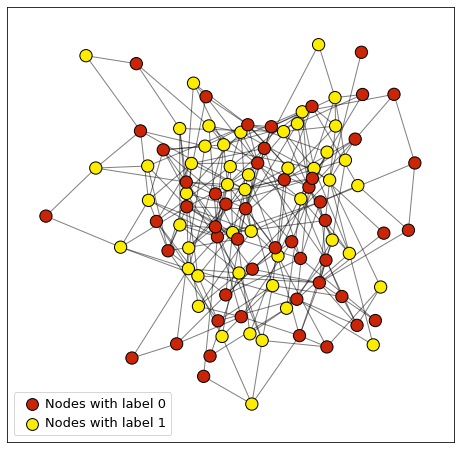

Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])
Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64
Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64
The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manupulation graph


In [11]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_nodes = 100
  p = 0.05
  seed = 100

  # Generate a networkx random graph
  G = nx.gnp_random_graph(num_nodes, p, seed=seed)

  # Generate some random node features and labels
  node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
  node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

  # Set the random features and labels to G
  nx.set_node_attributes(G, node_feature, name='node_feature')
  nx.set_node_attributes(G, node_label, name='node_label')

  # Print one node example
  for node in G.nodes(data=True):
    print(node)
    break

  color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]

  # Visualize the graph
  visualize(G, color_map=color_map)

  # Transform the networkx graph into the deepsnap graph
  graph = Graph(G)

  # Print out the general deepsnap graph information
  print(graph)

  # DeepSNAP will convert node attributes to tensors
  # Notice the type of tensors
  print("Node feature (node_feature) has shape {} and type {}".format(graph.node_feature.shape, graph.node_feature.dtype))
  print("Node label (node_label) has shape {} and type {}".format(graph.node_label.shape, graph.node_label.dtype))

  # DeepSNAP will also generate the edge_index tensor
  print("Edge index (edge_index) has shape {} and type {}".format(graph.edge_index.shape, graph.edge_index.dtype))

  # Different from only storing tensors, deepsnap graph also references to the networkx graph
  # We will discuss why the reference will be helpful later
  print("The DeepSNAP graph has {} as the internal manupulation graph".format(type(graph.G)))

### Tensor graph attributes

Similar to the native PyG tensor based representation, DeepSNAP includes a graph tensor based representation with three levels of graph attributes. In this example, you primarily have **node level** attributes including `node_feature` and `node_label`. The other two levels of attributes are **edge** and **graph** attributes. Similar to node level attributes, these attributes are prefixed by their respective type. For example, the features become `edge_feature` or `graph_feature` and labels becomes `edge_label` or `graph_label` etc.

### Graph Object
DeepSNAP allows you to easily access graph information  through the backend graph object and graph manipulation package.

In [12]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Number of nodes
  print("The random graph has {} nodes".format(graph.num_nodes))

  # Number of edges
  print("The random graph has {} edges".format(graph.num_edges))

The random graph has 100 nodes
The random graph has 262 edges


### PyG to DeepSNAP

Lastly, DeepSNAP provides functionality to automatically transform a PyG dataset into a list of DeepSNAP graphs.

Here you transform the CORA dataset into a list with one DeepSNAP graph (i.e. the singular CORA graph).

In [13]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  root = './tmp/cora'
  name = 'Cora'

  # The Cora dataset
  pyg_dataset= Planetoid(root, name)

  # PyG dataset to a list of deepsnap graphs
  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

  # Get the first deepsnap graph (CORA only has one graph)
  graph = graphs[0]
  print(graph)

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


## Question 2.1: How many classes are in the CORA graph? How many features does each node have? (5 points)


In [14]:
def get_num_node_classes(graph):
  # TODO: Implement a function that takes a deepsnap graph object
  # and return the number of node classes of that graph.

  num_node_classes = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
  num_node_classes = graph.num_node_labels
  ##########################################

  return num_node_classes

def get_num_node_features(graph):
  # TODO: Implement a function that takes a deepsnap graph object
  # and return the number of node features of that graph.

  num_node_features = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
  num_node_features = graph.num_node_features
  ##########################################

  return num_node_features

if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_node_classes = get_num_node_classes(graph)
  num_node_features = get_num_node_features(graph)
  print("{} has {} classes".format(name, num_node_classes))
  print("{} has {} features".format(name, num_node_features))

Cora has 7 classes
Cora has 1433 features


## DeepSNAP Dataset

Now, you will learn how to create DeepSNAP datasets. A `deepsnap.dataset.GraphDataset` contains a list of `deepsnap.graph.Graph` objects. In addition to the list of graphs, you must specify what task the dataset will be used on: node level task (`task=node`), edge level task (`task=link_pred`) and graph level task (`task=graph`).

The GraphDataset class contains many other useful parameters that can be specified during initialization. If you are interested, you can take a look at the [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset).

As an example, let us first look at the COX2 dataset, which contains 467 graphs. In initializing our dataset, convert the PyG dataset into its corresponding DeepSNAP dataset and specify the task to `graph`.

In [15]:
if 'IS_GRADESCOPE_ENV' not in os.environ:  
  root = './tmp/cox2'
  name = 'COX2'

  # Load the dataset through PyG
  pyg_dataset = TUDataset(root, name)

  # Convert to a list of deepsnap graphs
  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

  # Convert list of deepsnap graphs to deepsnap dataset with specified task=graph
  dataset = GraphDataset(graphs, task='graph')
  print(dataset)

GraphDataset(467)


## Question 2.2: What is the label of the graph with index 100? (5 points)

In [16]:
def get_graph_class(dataset, idx):
  # TODO: Implement a function that takes a deepsnap dataset object,
  # the index of a graph in the dataset, and returns the class/label 
  # of the graph (in integer).

  label = -1

  ############# Your code here ############
  ## (~1 line of code)
  ## Notice
  ## 1. The graph label refers to a graph-level attribute
  if idx >= len(dataset) or idx < 0:
    raise RuntimeError(f"idx out of range 0--{len(dataset)-1}")
  label = dataset[idx].graph_label.data[0]
  #########################################

  return label

if 'IS_GRADESCOPE_ENV' not in os.environ:
  graph_0 = dataset[0]
  print(graph_0)
  idx = 100
  label = get_graph_class(dataset, idx)
  print('Graph with index {} has label {}'.format(idx, label))

Graph(G=[], edge_index=[2, 82], edge_label_index=[2, 82], graph_label=[1], node_feature=[39, 35], node_label_index=[39], task=[])
Graph with index 100 has label 0


## Question 2.3: How many edges are in the graph with index 200? (5 points)


In [17]:
def get_graph_num_edges(dataset, idx):
  # TODO: Implement a function that takes a deepsnap dataset object,
  # the index of a graph in dataset, and returns the number of 
  # edges in the graph (in integer).

  num_edges = 0

  ############# Your code here ############
  ## (~1 lines of code)
  ## Note
  ## 1. You can use the class property directly
  if idx >= len(dataset) or idx < 0:
    raise RuntimeError(f"idx out of range 0--{len(dataset)-1}")
  num_edges = dataset[idx].num_edges
  #########################################

  return num_edges

if 'IS_GRADESCOPE_ENV' not in os.environ:
  idx = 200
  num_edges = get_graph_num_edges(dataset, idx)
  print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 49 edges


# 3) DeepSNAP Advanced

Now that you have learned the basics of DeepSNAP, let's move on to some more advanced functionalities.

In this section you will use DeepSNAP for graph feature computation and transductive/inductive dataset splitting.

## Setup

In [18]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

## Data Split in Graphs

As discussed in the `Module 2: Introduction to Graph Neural Networks / 2.3  GNN Training Pipeline / Setting up GNN Prediction Tasks` Lecture, data splitting for graphs can be much harder than for CV or NLP.

In general, data splitting is divided into two settings, **inductive** and **transductive**.

## Inductive Split

In an inductive setting, you split a list of multiple graphs into disjoint training/valiation and test sets.

Here is an example of using DeepSNAP to inductively split a list of graphs for a graph level task (graph classification etc.):

In [19]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  root = './tmp/cox2'
  name = 'COX2'

  pyg_dataset = TUDataset(root, name)

  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

  # Here we specify the task as graph-level task such as graph classification
  task = 'graph'
  dataset = GraphDataset(graphs, task=task)

  # Specify transductive=False (inductive)
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

  print("COX2 train dataset: {}".format(dataset_train))
  print("COX2 validation dataset: {}".format(dataset_val))
  print("COX2 test dataset: {}".format(dataset_test))

COX2 train dataset: GraphDataset(373)
COX2 validation dataset: GraphDataset(46)
COX2 test dataset: GraphDataset(48)


## Transductive Split

In the transductive setting, the training /validation / test sets are all over the same graph. As discussed in the `Module 2: Introduction to Graph Neural Networks / 2.3  GNN Training Pipeline / Setting up GNN Prediction Tasks` Lecture, in a transductive setting, we do not need to generalize to new unseen graphs. 

As an example, here you transductively split the CORA graph for a node level task, such as node classification. 

(Notice that in DeepSNAP the default split setting is random (i.e. DeepSNAP randomly splits the e.g. nodes into train / val / test); however, you can also use a fixed split by specifying `fixed_split=True` when loading the dataset from PyG or changing the `node_label_index` directly).

In [20]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  root = './tmp/cora'
  name = 'Cora'

  pyg_dataset = Planetoid(root, name)

  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

  # Here we specify the task as node-level task such as node classification
  task = 'node'

  dataset = GraphDataset(graphs, task=task)

  # Specify we want the transductive splitting
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

  print("Cora train dataset: {}".format(dataset_train))
  print("Cora validation dataset: {}".format(dataset_val))
  print("Cora test dataset: {}".format(dataset_test))

  print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

  # The nodes in each set can be find in node_label_index
  print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
  print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
  print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)
Original Cora has 2708 nodes
After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


## Edge Level Split

Compared to node and graph level splitting, edge level splitting is a little bit tricky ;)

For edge level splitting you need to consider several different tasks:

1. Splitting positive edges into train / val / test datasets.
2. Sampling / re-sampling negative edges (i.e. edges not present in the graph).
3. Splitting edges into message passing and supervision edges.

With regard to point 3, for edge level data splitting we classify edges into two types. The first is `message passing` edges, edges that are used for message passing by our GNN. The second is `supervision`, edges that are used in the loss function for backpropagation. DeepSNAP allows for two different modes, where the `message passing` and `supervision` edges are either the same or disjoint.

### All Edge Splitting Mode

First, you will explore the `edge_train_mode="all"` mode for edge level splitting, where the `message passing` and `supervision` edges are shared during training.

In [21]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  root = './tmp/cora'
  name = 'Cora'

  pyg_dataset = Planetoid(root, name)

  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

  # Specify task as link_pred for edge-level task
  task = 'link_pred'

  # Specify the train mode, "all" mode is default for deepsnap dataset
  edge_train_mode = "all"

  dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

  # Transductive link prediction split
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

  print("Cora train dataset: {}".format(dataset_train))
  print("Cora validation dataset: {}".format(dataset_val))
  print("Cora test dataset: {}".format(dataset_test))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


/home/john/anaconda3/envs/pgenv/lib/python3.8/site-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In DeepSNAP, the indices of supervision edges are stored in the `edge_label_index` tensor and the corresponding edge labels are stored in `edge_label` tensor.

In [22]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  print("Original Cora graph has {} edges".format(dataset[0].num_edges))
  print()

  print("Train set has {} message passing edge".format(dataset_train[0].edge_index.shape[1] // 2))
  print("Train set has {} supervision (positive) edges".format(dataset_train[0].edge_label_index.shape[1] // 4))

  print()
  print("Validation set has {} message passing edge".format(dataset_val[0].edge_index.shape[1] // 2))
  print("Validation set has {} supervision (positive) edges".format(dataset_val[0].edge_label_index.shape[1] // 4))

  print()
  print("Test set has {} message passing edge".format(dataset_test[0].edge_index.shape[1] // 2))
  print("Test set has {} supervision (positive) edges".format(dataset_test[0].edge_label_index.shape[1] // 4))

Original Cora graph has 5278 edges

Train set has 4222 message passing edge
Train set has 4222 supervision (positive) edges

Validation set has 4222 message passing edge
Validation set has 527 supervision (positive) edges

Test set has 4749 message passing edge
Test set has 529 supervision (positive) edges


**Specific things to note in `all` mode**:

* At training time: the supervision edges are the same as the training message passing edges.  
* At validation time: the message passing edges are the training message passing edges and training supervision edges (still the training message passing edges in this case). However, you now include a set of unseen validation supervision edges that are disjoint from the training supervision edges.
* At test time: the message passing edges are the union of training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges then disjoint from the training supervision edges and validation supervision edges.
* For this illustration negative edges are excluded. However, the attributes `edge_label` and `edge_label_index` naturally also include the negative supervision edges (by default the number of negative edges is the same as the number of positive edges, hence the divide by 4 above).


Now, that you have seen the basics of the `all` method for edge splitting, you will implement a function that checks whether two edge index tensors are disjoint and explore more edge splitting properties by using that function.

## Question 3: Implement a function that checks whether two edge_index tensors are disjoint (i.e. do not share any common edges). Then answer the True/False questions below. (10 points)



In [23]:
def edge_indices_disjoint(edge_index_1, edge_index_2):
  # TODO: Implement this function that takes two edge index tensors,
  # and returns whether these two edge index tensors are disjoint.
  disjoint = None

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Here disjoint means that there is no single edge belonging to both edge index tensors
  ## 2. You do not need to consider the undirected case. For example, if edge_index_1 contains
  ## edge (a, b) and edge_index_2 contains edge (b, a). We will treat them as disjoint in this
  ## function.
  set1 = set([(f, t) for f, t in zip(edge_index_1[0].tolist(), edge_index_1[1].tolist())])
  set2 = set([(f, t) for f, t in zip(edge_index_2[0].tolist(), edge_index_2[1].tolist())])
  disjoint =  len(set1.intersection(set2))==0
    
  #########################################

  return disjoint

In [24]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
  train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
  train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
  print("3.1 Training (supervision) positve and negative edges are disjoint = {}"\
          .format(edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)))

  num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
  val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
  val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
  print("3.2 Validation (supervision) positve and negative edges are disjoint = {}"\
          .format(edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)))

  num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
  test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
  test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
  print("3.3 Test (supervision) positve and negative edges are disjoint = {}"\
          .format(edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)))

  print("3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = {}"\
          .format(edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)))
  print("3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = {}"\
          .format(edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)))

3.1 Training (supervision) positve and negative edges are disjoint = True
3.2 Validation (supervision) positve and negative edges are disjoint = True
3.3 Test (supervision) positve and negative edges are disjoint = True
3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = True
3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = True


### Disjoint Edge Splitting Mode

Now you will look at a relatively more complex transductive edge split setting, the `edge_train_mode="disjoint"` mode in DeepSNAP. In this setting, the `message passing` and `supervision` edges are completely disjoint

In [25]:
if 'IS_GRADESCOPE_ENV' not in os.environ:  
  edge_train_mode = "disjoint"

  dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
  orig_edge_index = dataset[0].edge_index
  dataset_train, dataset_val, dataset_test = dataset.split(
      transductive=True, split_ratio=[0.8, 0.1, 0.1])

  train_message_edge_index = dataset_train[0].edge_index
  train_sup_edge_index = dataset_train[0].edge_label_index
  val_message_edge_index = dataset_val[0].edge_index
  val_sup_edge_index = dataset_val[0].edge_label_index
  test_message_edge_index = dataset_test[0].edge_index
  test_sup_edge_index = dataset_test[0].edge_label_index

  print("Original Cora graph has {} edges".format(dataset[0].num_edges))
  print()
  print("Train set has {} message passing edge".format(train_message_edge_index.shape[1] // 2))
  print("Train set has {} supervision (positive) edges".format(train_sup_edge_index.shape[1] // 4))

  print()
  print("Validation set has {} message passing edge".format(val_message_edge_index.shape[1] // 2))
  print("Validation set has {} supervision (positive) edges".format(val_sup_edge_index.shape[1] // 4))

  print()
  print("Test set has {} message passing edge".format(test_message_edge_index.shape[1] // 2))
  print("Test set has {} supervision (positive) edges".format(test_sup_edge_index.shape[1] // 4))

Original Cora graph has 5278 edges

Train set has 3377 message passing edge
Train set has 845 supervision (positive) edges

Validation set has 4222 message passing edge
Validation set has 527 supervision (positive) edges

Test set has 4749 message passing edge
Test set has 529 supervision (positive) edges



**Specific things to note in `disjoint` mode**:

* At training time: the training supervision edges are disjoint from the training message passing edges.
* At validation time: the message passing edges are the union of training message passing edges and training supervision edges. The validation supervision edges are disjoint from both the training message passing and supervision edges.
* At test time: the message passing edges are the training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges are disjoint from all the training and validation edges.

## Negative Edges

For edge level tasks, sampling negative edges (edges not present in the graph) is critical. Moreover, during each training iteration, you want to resample the negative edges.

Below we print the training and validation sets negative edges in two training iterations.

What we demonstrate is that the negative edges are only resampled during training.

In [26]:
if 'IS_GRADESCOPE_ENV' not in os.environ:  
  dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
  datasets = {}
  follow_batch = []
  datasets['train'], datasets['val'], datasets['test'] = dataset.split(
      transductive=True, split_ratio=[0.8, 0.1, 0.1])
  dataloaders = {
    split: DataLoader(
      ds, collate_fn=Batch.collate(follow_batch),
      batch_size=1, shuffle=(split=='train')
    )
    for split, ds in datasets.items()
  }
  neg_edges_1 = None
  for batch in dataloaders['train']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_1 = batch.edge_label_index[:, num_edges:]
    print("First iteration training negative edges:")
    print(neg_edges_1)
    break
  neg_edges_2 = None
  for batch in dataloaders['train']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_2 = batch.edge_label_index[:, num_edges:]
    print("Second iteration training negative edges:")
    print(neg_edges_2)
    break

  neg_edges_1 = None
  for batch in dataloaders['val']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_1 = batch.edge_label_index[:, num_edges:]
    print("First iteration validation negative edges:")
    print(neg_edges_1)
    break
  neg_edges_2 = None
  for batch in dataloaders['val']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_2 = batch.edge_label_index[:, num_edges:]
    print("Second iteration validation negative edges:")
    print(neg_edges_2)
    break

First iteration training negative edges:
tensor([[2236, 2614, 2240,  ..., 2470, 1184,  220],
        [1263,  942, 1648,  ..., 1300, 1821, 2297]])
Second iteration training negative edges:
tensor([[ 919, 1856,  608,  ...,  652, 1450,  879],
        [2623, 1138, 1607,  ..., 2097,  633, 1987]])
First iteration validation negative edges:
tensor([[1690, 2490, 2249,  ..., 2641,  946, 2428],
        [2399,  801, 2324,  ..., 2516, 2275,  129]])
Second iteration validation negative edges:
tensor([[1690, 2490, 2249,  ..., 2641,  946, 2428],
        [2399,  801, 2324,  ..., 2516, 2275,  129]])


If you are interested in more graph splitting settings, please refer to the DeepSNAP dataset [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html).

## Graph Transformation and Feature Computation

The other core functionality of DeepSNAP is graph transformation / feature computation.

In DeepSNAP, graph transformation / feature computation is divided into two different types. The first includes transformations before training (e.g. transform the whole dataset before training directly), and the second includes transformations during training (transform batches of graphs).

Below is an example that uses the NetworkX back end to calculate the PageRank value for each node and subsequently transforms the node features by concatenating each nodes PageRank score (transform the dataset before training).

In [27]:
def pagerank_transform_fn(graph):

  # Get the referenced networkx graph
  G = graph.G

  # Calculate the pagerank by using networkx
  pr = nx.pagerank(G)

  # Transform the pagerank values to tensor
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

if 'IS_GRADESCOPE_ENV' not in os.environ:
  root = './tmp/cox2'
  name = 'COX2'
  pyg_dataset = TUDataset(root, name)
  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
  dataset = GraphDataset(graphs, task='graph')
  print("Number of features before transformation: {}".format(dataset.num_node_features))
  dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
  print("Number of features after transformation: {}".format(dataset.num_node_features))

Number of features before transformation: 35
Number of features after transformation: 36


## Question 4: Implement a transformation that adds the clustering coefficient of each node to its feature vector and then report the clustering coefficient of the node with index 3 in the graph with index 406 (10 points).

In [28]:
def cluster_transform_fn(graph):
  # TODO: Implement a function that takes an deepsnap graph object and 
  # transform the graph by adding each node's clustering coefficient to its 
  # graph.node_feature representation

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Compute the clustering coefficient value for each node and
  ## concat this value to the last dimension of graph.node_feature
  ng = graph.G
  ccdict = nx.clustering(ng, ng.nodes)
  ccvals = torch.tensor(list(ccdict.values())).unsqueeze(dim=-1)
  nfeature = graph.node_feature
  graph.node_feature = torch.cat((nfeature, ccvals), dim=1)
  #########################################

if 'IS_GRADESCOPE_ENV' not in os.environ:
  root = './cox2'
  name = 'COX2'
  pyg_dataset = TUDataset(root, name)
  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
  dataset = GraphDataset(graphs, task='graph')

  # Transform the dataset
  dataset.apply_transform(cluster_transform_fn, update_tensor=False)

  node_idx = 3
  graph_idx = 406
  node_feature = dataset[graph_idx].node_feature

  print("The node has clustering coefficient: {}".format(round(node_feature[node_idx][-1].item(), 2)))

The node has clustering coefficient: 0.17


### Final Thoughts
Apart from transforming the whole dataset before training, DeepSNAP can also transform the graph (usually sampled batches of graphs, `deepsnap.batch.Batch`) during each training iteration.

Also, DeepSNAP supports the synchronization of the transformation between the referenced graph objects and tensor representations. For example, you can just update the NetworkX graph object in the transform function, and by specifying `update_tensor=True` the internal tensor representations will be automatically updated!

For more information, please refer to the DeepSNAP [documentation](https://snap.stanford.edu/deepsnap/).

# 4) Edge Level Prediction

From the last section, you learned how DeepSNAP transductively splits edges for edge level tasks. For the last part of the notebook, you will use DeepSNAP and PyG together to implement a simple edge level prediction (link prediction) model!

Specifically, you will use a 2 layer GraphSAGE embedding model to generate node embeddings, and then compute link predictions through a dot product link prediction head. Namely, given an edge (u, v) with GNN feature embeddings $f_u$ and $f_v$, our link prediction head generates its link prediction as $f_u \cdot f_v$. 

To give a brief intuition for this dot product link prediction model, we are learning a GNN that embedds nodes such that nodes that have an edge in the graph are closer within the embedding space than nodes that do not have an edge. The dot product provides a proxy for closeness in our embedding space where a high positive dot product indicates that two vectors are more closely aligned (the angle between the vectors is small), whereas a negative dot-product indicates that vectors are unaligned (the angle between the vectors is greater than 90). 

In [29]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = None

        ############# Your code here #############
        ## (~1 line of code)
        ## Note
        ## 1. Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        ##########################################

        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Your code here #############
        ## (~6 line of code)
        ## Note
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source and destination 
        ## nodes of each edge by using the edge_label_index and 
        ## compute the dot product similarity of each pair.
        
        import pdb
        #pdb.set_trace()         
        x1 = self.conv1(node_feature, edge_label_index)
        x2 = F.relu(x1)
        x3 = F.dropout(x2, p=self.dropout)
        x4 = self.conv2(x3, edge_index)
       
        left =   x4[edge_label_index[0]]
        right =  x4[edge_label_index[1]]
  
        temp = left * right
        pred = temp.sum(axis=1)    
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [30]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Your code here #############
            ## (~6 lines of code)
            ## Note
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters

            optimizer.zero_grad()
            pred = model(batch)         
            label = batch.edge_label.float()           
            loss = model.loss(pred, label)
            #print(f"{pred.requires_grad}  {loss.requires_grad}")          
            loss.backward()
            optimizer.step()

            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args, save_model_preds=False):
    model.eval()

    score = 0
    preds = None
    labels = None

    ############# Your code here #############
    ## (~7 lines of code)
    ## Note
    ## 1. Loop through batches in the dataloader (Note for us there is only one batch!)
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ##    Note: Look into flattening and converting torch tensors into numpy arrays
    ## 5. Edge labels are stored in batch.edge_label
    ## 6. Make sure to save your **numpy** model predictions as 'preds' 
    ##    and the **numpy** edge labels as 'labels'
    for i, batch in enumerate(dataloader):
        batch.to(args["device"])
        
        #setup for test
        dropout = model.dropout
        model.dropout = 0
        #edge_label_index = batch.edge_label_index
        #batch.edge_label_index = batch.edge_index
        
        # run test
        preds_t = model(batch)
        
        # return to original values
        #batch.edge_label_index = edge_label_index
        model.dropout = dropout
        
        preds_t = torch.sigmoid(preds_t)
        labels_t = batch.edge_label.float()
        import pdb         
        preds = preds_t.cpu().data.numpy()
        labels = labels_t.cpu().data.numpy()    
          
        score = roc_auc_score(labels, preds)            
    ##########################################

    if save_model_preds:
        print ("Saving Link Classification Model Predictions")
        print()

        data = {}
        data['pred'] = preds
        data['label'] = labels

        df = pd.DataFrame(data=data)
        # Save locally as csv
        df.to_csv('CORA-Link-Prediction.csv', sep=',', index=False)
 
    return score

In [31]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [32]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  import warnings
  warnings.filterwarnings('ignore')    
  pyg_dataset = Planetoid('./tmp/cora', 'Cora')
  graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

  dataset = GraphDataset(
          graphs,
          task='link_pred',
          edge_train_mode="disjoint"
      )
  datasets = {}
  datasets['train'], datasets['val'], datasets['test']= dataset.split(
              transductive=True, 
              split_ratio=[0.85, 0.05, 0.1])
  input_dim = datasets['train'].num_node_features
  num_classes = datasets['train'].num_edge_labels

  model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
  model.reset_parameters()

  optimizer = torch.optim.SGD(model.parameters(), 
                              lr = 0.05, #lr=0.1, 
                              momentum=0.9, 
                              weight_decay=5e-4)

  dataloaders = {split: DataLoader(
              ds, collate_fn=Batch.collate([]),
              batch_size=1, shuffle=(split=='train'))
              for split, ds in datasets.items()}
  best_model = train(model, dataloaders, optimizer, args)
  log = "Best Model Accuraies Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
  best_train_roc = test(best_model, dataloaders['train'], args)
  best_val_roc = test(best_model, dataloaders['val'], args)
  best_test_roc = test(best_model, dataloaders['test'], args, save_model_preds=True)
  print(log.format(best_train_roc, best_val_roc, best_test_roc))

Epoch: 001, Train: 0.5007, Val: 0.5270, Test: 0.5007, Loss: 0.6931045055389404
Epoch: 002, Train: 0.5079, Val: 0.5274, Test: 0.5009, Loss: 0.6930977702140808
Epoch: 003, Train: 0.5051, Val: 0.5281, Test: 0.5012, Loss: 0.6930539011955261
Epoch: 004, Train: 0.5198, Val: 0.5289, Test: 0.5018, Loss: 0.6930626630783081
Epoch: 005, Train: 0.5221, Val: 0.5297, Test: 0.5023, Loss: 0.6930862069129944
Epoch: 006, Train: 0.5168, Val: 0.5306, Test: 0.5029, Loss: 0.6931284666061401
Epoch: 007, Train: 0.5162, Val: 0.5315, Test: 0.5036, Loss: 0.693112850189209
Epoch: 008, Train: 0.5054, Val: 0.5326, Test: 0.5044, Loss: 0.693048357963562
Epoch: 009, Train: 0.5021, Val: 0.5341, Test: 0.5053, Loss: 0.6931183934211731
Epoch: 010, Train: 0.5116, Val: 0.5354, Test: 0.5062, Loss: 0.6931092143058777
Epoch: 011, Train: 0.5268, Val: 0.5364, Test: 0.5070, Loss: 0.6931222081184387
Epoch: 012, Train: 0.5168, Val: 0.5378, Test: 0.5079, Loss: 0.6930568218231201
Epoch: 013, Train: 0.5034, Val: 0.5391, Test: 0.5088, 

Epoch: 105, Train: 0.6651, Val: 0.6860, Test: 0.6397, Loss: 0.6906417012214661
Epoch: 106, Train: 0.6563, Val: 0.6870, Test: 0.6406, Loss: 0.6903442144393921
Epoch: 107, Train: 0.6549, Val: 0.6880, Test: 0.6417, Loss: 0.6900840997695923
Epoch: 108, Train: 0.6677, Val: 0.6890, Test: 0.6425, Loss: 0.6902216076850891
Epoch: 109, Train: 0.6577, Val: 0.6903, Test: 0.6434, Loss: 0.690008282661438
Epoch: 110, Train: 0.6615, Val: 0.6913, Test: 0.6444, Loss: 0.6895139217376709
Epoch: 111, Train: 0.6612, Val: 0.6923, Test: 0.6453, Loss: 0.6891807317733765
Epoch: 112, Train: 0.6655, Val: 0.6932, Test: 0.6461, Loss: 0.6889434456825256
Epoch: 113, Train: 0.6475, Val: 0.6943, Test: 0.6468, Loss: 0.6892916560173035
Epoch: 114, Train: 0.6737, Val: 0.6954, Test: 0.6477, Loss: 0.6891481876373291
Epoch: 115, Train: 0.6634, Val: 0.6966, Test: 0.6485, Loss: 0.6889076232910156
Epoch: 116, Train: 0.6537, Val: 0.6976, Test: 0.6492, Loss: 0.6887960433959961
Epoch: 117, Train: 0.6636, Val: 0.6983, Test: 0.6500,

In [33]:
if False:
    import pandas as pd
    df = pd.read_csv('CORA-Link-Prediction.csv', sep=',')
    df.head()

## Question 5: What is the maximum ROC-AUC score you get for your best_model on test set? (15 points)


After training your model, download and submit your best model prediction file: *CORA-Link-Prediction.csv*.  

As we have seen before you can view this file by clicking on the *Folder* icon on the left side pannel. 

# Submission

You will need to submit four files on Gradescope to complete this notebook. 

1.   Your completed *XCS224W_Colab3.ipynb*. From the "File" menu select "Download .ipynb" to save a local copy of your completed Colab. 
2.  *CORA-Node-GraphSage.csv* 
3.  *CORA-Node-GAT.csv*
4.  *CORA-Link-Prediction.csv*

Download the csv files by selecting the *Folder* icon on the left panel. 

To submit your work, zip the files downloaded in steps 1-4 above and submit to gradescope. **NOTE:** DO NOT rename any of the downloaded files. 